In [1]:
import numpy as np
import copy
import cv2
import matplotlib.pyplot as plt
import cv2 as cv
import torch
import random as rnd
from IPython.display import clear_output 
from scipy import signal
from scipy import misc
from simulation import *
clear_output()

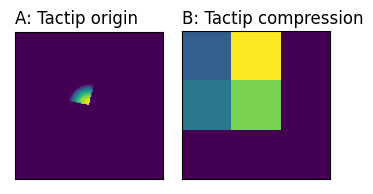

In [2]:
o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0


def get_image(observation,div=2):
    observation = cv2.resize(observation, dsize=(128,128), interpolation=cv2.INTER_AREA) #rescale
    im=observation
    im=im[44:84,44:83]
    quaters = cv2.resize(im, dsize=(div,div), interpolation=cv2.INTER_AREA) #rescale
    return quaters


#im=o['tactile']
#im=im[44:84,44:83]
#print(len(o['tactile']))
fig, axes = plt.subplots(1,2, figsize=(3.5, 2.0))
#axes[0].figure(figsize=(5,1))
axes[0].set_title("A: Tactip origin", loc="left")
axes[0].imshow(o['tactile'])
axes[0].xaxis.set_visible(False)
axes[0].yaxis.set_visible(False)
#axes[1].figure(figsize=(5,1))
axes[1].set_title("B: Tactip compression", loc="left")
axes[1].imshow(get_image(o['tactile'],div=3))
axes[1].xaxis.set_visible(False)
axes[1].yaxis.set_visible(False)
axes[1].set_aspect("equal")
fig.tight_layout()
fig.savefig("./"+"save"+".pdf")


In [3]:
class Agent_Conv2D:
    def __init__(self, num_input, layers, num_output):
        assert type(layers)==type([]), "Error with layers, give array of the number of layers"
        self.num_input = num_input  #set input number
        self.num_output = num_output #set ooutput number
        self.hidden=[]
        last=num_input
        self.num_genes=0
        for layer in layers:
            self.hidden.append(layer)
            self.num_genes+=(last * layer)
            last=layer
        self.num_genes +=(self.hidden[-1]*num_output)+num_output
        self.weights = None
        self.hidden_weights=None
        self.bias = None
        print("Auto",self.num_genes)
    def set_genes(self, gene):
        weight_idxs = self.num_input * self.hidden[0] #size of weights to hidden
        current=weight_idxs
        weights_idxs=[current] #start with end of last
        for i in range(len(self.hidden)-1):
            current+=self.hidden[i]*self.hidden[i+1] #calculate next idx for each layer
            weights_idxs.append(current)
        bias_idxs=None
        weights_idxs.append(self.hidden[-1] * self.num_output + weights_idxs[-1]) #add last layer heading to output
        bias_idxs = weights_idxs[-1]+ self.num_output #sizes of biases
        w = gene[0 : weight_idxs].reshape(self.hidden[0], self.num_input)   #merge genes
        ws=[]
        for i in range(len(self.hidden)-1):
            ws.append(gene[weights_idxs[i] : weights_idxs[i+1]].reshape(self.hidden[i+1], self.hidden[i]))
        ws.append(gene[weights_idxs[-2] : weights_idxs[-1]].reshape(self.num_output, self.hidden[-1]))
        b = gene[weights_idxs[-1]: bias_idxs].reshape(self.num_output,) #merge genes

        self.weights = torch.from_numpy(w) #assign weights
        self.hidden_weights=[]
        for w in ws:
            self.hidden_weights.append(torch.from_numpy(w))
        self.bias = torch.from_numpy(b) #assign biases

    def forward(self, x):
        #create conv layer
        scharr = np.array([[ -3-3, 0-10,  +3 -3],
                   [-10+0, 0+ 0, +10 +0],
                   [ -3+3, 0+10,  +3 +3]]) # Gx + j*Gy
        x= signal.convolve2d(x, scharr, boundary='symm', mode='same')   
        x=x.flatten()
        x=torch.tensor(x[:,np.newaxis]).float()  
        #x = torch.tensor(np.dot(self.weights.float(),x).flatten()).float()
        #run through forward layers
        x = torch.mm(x.T, self.weights.T.float()) #first layer

        for i in range(len(self.hidden_weights)-1):
            x = torch.mm(x,self.hidden_weights[i].T.float()) #second layer
        x=torch.sigmoid(x)
        return torch.mm(x,self.hidden_weights[-1].T.float()) + self.bias #third layer
    
    def get_action(self, x):
        vectors=[(1,1),(1,0),(0,1),(-1,-1),(-1,0),(0,-1),(-1,1),(1,-1),(0,0)] #possible moves
        arr=self.forward(x)[0]
        ind=np.argmax(arr)
        return np.array(vectors[ind])
    
class Agent:
    def __init__(self, num_input, layers, num_output):
        assert type(layers)==type([]), "Error with layers, give array of the number of layers"
        self.num_input = num_input  #set input number
        self.num_output = num_output #set ooutput number
        self.hidden=[]
        last=num_input
        self.num_genes=0
        for layer in layers:
            self.hidden.append(layer)
            self.num_genes+=(last * layer)
            last=layer
        self.num_genes +=(self.hidden[-1]*num_output)+num_output
        self.weights = None
        self.hidden_weights=None
        self.bias = None
        print("Auto",self.num_genes)
    def set_genes(self, gene):
        weight_idxs = self.num_input * self.hidden[0] #size of weights to hidden
        current=weight_idxs
        weights_idxs=[current] #start with end of last
        for i in range(len(self.hidden)-1):
            current+=self.hidden[i]*self.hidden[i+1] #calculate next idx for each layer
            weights_idxs.append(current)
        bias_idxs=None
        weights_idxs.append(self.hidden[-1] * self.num_output + weights_idxs[-1]) #add last layer heading to output
        bias_idxs = weights_idxs[-1]+ self.num_output #sizes of biases
        w = gene[0 : weight_idxs].reshape(self.hidden[0], self.num_input)   #merge genes
        ws=[]
        for i in range(len(self.hidden)-1):
            ws.append(gene[weights_idxs[i] : weights_idxs[i+1]].reshape(self.hidden[i+1], self.hidden[i]))
        ws.append(gene[weights_idxs[-2] : weights_idxs[-1]].reshape(self.num_output, self.hidden[-1]))
        b = gene[weights_idxs[-1]: bias_idxs].reshape(self.num_output,) #merge genes

        self.weights = torch.from_numpy(w) #assign weights
        self.hidden_weights=[]
        for w in ws:
            self.hidden_weights.append(torch.from_numpy(w))
        self.bias = torch.from_numpy(b) #assign biases

    def forward(self, x):
        x=x.flatten()
        x=torch.tensor(x[:,np.newaxis]).float()  
        #x = torch.tensor(np.dot(self.weights.float(),x).flatten()).float()
        #run through forward layers
        x = torch.mm(x.T, self.weights.T.float()) #first layer

        for i in range(len(self.hidden_weights)-1):
            x = torch.mm(x,self.hidden_weights[i].T.float()) #second layer
        x=torch.sigmoid(x)
        return torch.mm(x,self.hidden_weights[-1].T.float()) + self.bias #third layer
    
    def get_action(self, x):
        vectors=[(1,1),(1,0),(0,1),(-1,-1),(-1,0),(0,-1),(-1,1),(1,-1)] #possible moves
        arr=self.forward(x)[0]
        ind=np.argmax(arr)
        return np.array(vectors[ind])
    

DIM=3
MASTER = cv2.imread("/its/home/drs25/Pictures/good.png")
MASTER=get_image(MASTER,div=DIM)
MASTER = cv2.cvtColor(MASTER, cv2.COLOR_BGR2GRAY)

def get_similarity(img1,img2):
    diff = np.abs(img1-img2)#cv2.absdiff(img1, img2) 
    return (np.sum(diff))/(DIM*DIM*255)

def new_fitness(tactile,old_tactile):
    img1=np.copy(tactile)
    img2=np.copy(old_tactile)
    img1[img1>0]=1
    img2[img2>0]=1
    new=int(np.sum(img1))
    old=int(np.sum(img2))
    sim=get_similarity(MASTER,img2)
    return 0 if new-old<0 else (((new-old)/(DIM*DIM*255)) + (sim))
    
def fitness(tactile):
    #lets say we want to maximize the lighter pixels 
    all=np.sum(tactile)
    if all==0: return 0
    all=(all)/(DIM*DIM*255)
    return all
def mutation(gene, mean=0, std=1,size=20):
    assert size<len(gene)
    n=rnd.randint(0,len(gene)-size-1)
    array=np.random.normal(mean,std,size=size)
    gene[n:n+size] += array #mutate the gene via normal 
    # constraint
    gene[gene >4] = 4
    gene[gene < -4] = -4
    return gene

def crossover(loser, winner, p_crossover=0.5): #provide a crossover function
    for i,gene in enumerate(winner):
      if rnd.random() <= p_crossover:
        loser[i] = winner[i]
    return loser

def run_trial(sensor,gene,max_t,save=None):
    dt=0.1
    t=0
    done=False
    r_sum = 0
    o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0
    step = 0
    sensor.set_genes(gene) #set the gene of the robot
    im=get_image(o['tactile'],div=DIM)
    old=copy.deepcopy(im)
    actions=[]
    while not done and t<=max_t: #loop till sturdy or out of time
        tactile_input=get_image(o['tactile'],div=DIM)     
        a=sensor.get_action(tactile_input.flatten()) #push through tactile input into agent
        actions.append(a)
        # step the environment
        o, r, d, info = env.step(a) #step through environment
        #print(a,env.action_space.sample())
        if True:#t%0.2==0 and t!=0: #allow significant change
            fit=new_fitness(tactile_input,old)
            old=copy.deepcopy(tactile_input) #make last frame
            if fit==0: 
                r_sum*=0.1 #add to decrease movement
                done=True #end if lost
            elif get_similarity(tactile_input,MASTER)==1:
                print("done")
                done=True
            r_sum +=fit #* max(1,2**(max_t-t))#the reward becomes more important over time
        #if fit>=0.5: done=True #if it is sturdy
        t+=dt #increase by timestep
        if save!=None: 
            save.append(env.render())
    #actions_=list(filter((0,0).__ne__, actions))
    #if len(actions_)<=len(actions)//2: r_sum=0 #dont allow zero movement
    return r_sum, env.render() #we care about the last fitnesses as it should be sturdy

def record_trial(sensor,genotype,max_t):
    dt=0.1
    t=0
    done=False
    r_sum = 0
    o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0
    step = 0
    sensor.set_genes(genotype) #set the gene of the robot
    im=get_image(o['tactile'],div=DIM)
    old=copy.deepcopy(im)
    while t<=max_t: #loop till sturdy or out of time
        tactile_input=get_image(o['tactile'],div=DIM)  
        
        a=sensor.get_action(tactile_input.flatten()) #push through tactile input into agent
        o, r, d, info = env.step(a) #step through environment
        fig, axes = plt.subplots(1,2, figsize=(3.5, 2.0))
        #axes[0].figure(figsize=(5,1))
        axes[0].set_title("A: Tactip", loc="left")
        axes[0].imshow(o['tactile'])
        axes[0].xaxis.set_visible(False)
        axes[0].yaxis.set_visible(False)
        #axes[1].figure(figsize=(5,1))
        axes[1].set_title("B: Vector", loc="left")
        axes[1].arrow(0, 0, a[0], a[1], head_width=0.2, head_length=0.1, length_includes_head=True, facecolor="black")
        axes[1].set_xlim((-1.1, 1.1))
        axes[1].set_ylim((-1.1, 1.1))
        axes[1].set_aspect("equal")
        fig.tight_layout()
        fig.savefig("./"+"save"+".pdf")
        ad=cv.imread("./"+"save"+".pdf")
        fig.savefig("././toMake/"+"save"+str(step)+".png")
        fig.clear()
        #ad=cv.imread("././toMake/"+"save"+str(step)+".png")
        step+=1
        t+=dt #increase by timestep

def run_microbial(sensor,population,generations): #microbial algorithm trial
    fitnesses=[0]
    rendered=[]
    bestInd=-1
    r1=None
    r2=None
    f1=0
    try:
        for gen in range(generations):
            clear_output()
            print("GEN: ",gen,"REWARD: ",fitnesses[-1],str(f1/3))
            try:
                plt.title("Best at epoch")
                plt.imshow(rendered[-1])
                plt.show()
            except:
                pass
            #select neighbouring genes
            ind_1 = rnd.randint(0,len(population)-1)
            ind_2=ind_1+1
            if ind_2 >= len(population): ind_2=ind_1-1
            #get two random positions
            gene1=population[ind_1]
            gene2=population[ind_2]
            #run trials for 20 seconds in sim time
            f1=0
            r=None
            for i in range(3): #run 3 trials to make sure there is no fluke
                f,r=run_trial(sensor,gene1,3)
                if f>f1/(i+1): r1=copy.deepcopy(r)
                f1+=f
            fit1=f1/3 #get average performance
            f2=0
            for i in range(3): #run 3 trials for fluke
                f,r=run_trial(sensor,gene2,3)
                if f>f2/(i+1): r2=copy.deepcopy(r)
                f2+=f
            fit2=f2/3
            if fit1>fitnesses[-1] and fit1<fit2: 
                rendered.append(r1)
                bestInd=ind_1
            elif fit2>fitnesses[-1]:
                rendered.append(r2)
                bestInd=ind_2
            fitnesses.append(max([fitnesses[-1],fit1,fit2]))
            #selection
            if fit1>fit2:
                gene2=copy.deepcopy((gene1)) #crossover
                population[ind_2]=copy.deepcopy(crossover(gene2,mutation(gene1)))
            elif fit2>fit1:
                gene1=copy.deepcopy((gene2)) #crossover
                population[ind_1]=copy.deepcopy(crossover(gene1,mutation(gene2)))
    except KeyboardInterrupt:
        pass
            
    return fitnesses, rendered, bestInd

GEN:  149 REWARD:  10.575744371822802 0.11760348583877996


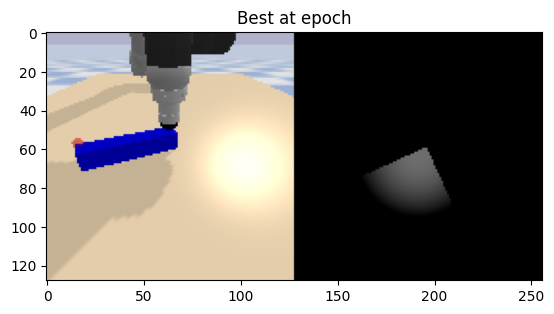

In [4]:
DIM=3
MASTER = cv2.imread("/its/home/drs25/Pictures/good.png")
MASTER=get_image(MASTER,div=DIM)
MASTER = cv2.cvtColor(MASTER, cv2.COLOR_BGR2GRAY)

sensor=Agent(DIM*DIM,[25],8)
#sensor=Agent(DIM*DIM,100,60,30],8)
size=sensor.num_genes
def gen_population(pop_size=25):
    population=np.random.normal(0,3,(pop_size,size))
    return population


GENERATIONS=150
pop=gen_population(pop_size=20)
f1,r1,ind1=run_microbial(sensor,pop,GENERATIONS)

GEN:  149 REWARD:  7.352886901960786 0.09423592156862744


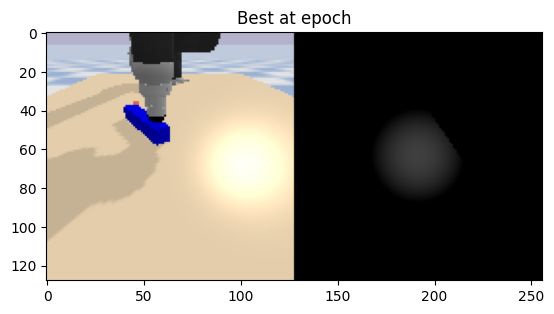

In [59]:
fitnesses=[]
labels=["3","6","9","18","25","50"]
for i in range(len(labels)):
    DIM=int(labels[i])
    MASTER = cv2.imread("/its/home/drs25/Pictures/good.png")
    MASTER=get_image(MASTER,div=DIM)
    MASTER = cv2.cvtColor(MASTER, cv2.COLOR_BGR2GRAY)

    sensor=Agent(DIM*DIM,[25],8)
    #sensor=Agent(DIM*DIM,100,60,30],8)
    size=sensor.num_genes
    def gen_population(pop_size=25):
        population=np.random.normal(0,3,(pop_size,size))
        return population


    GENERATIONS=150
    pop=gen_population(pop_size=20)
    f1,r1,ind1=run_microbial(sensor,pop,GENERATIONS)
    fitnesses.append(copy.deepcopy(f1))


6


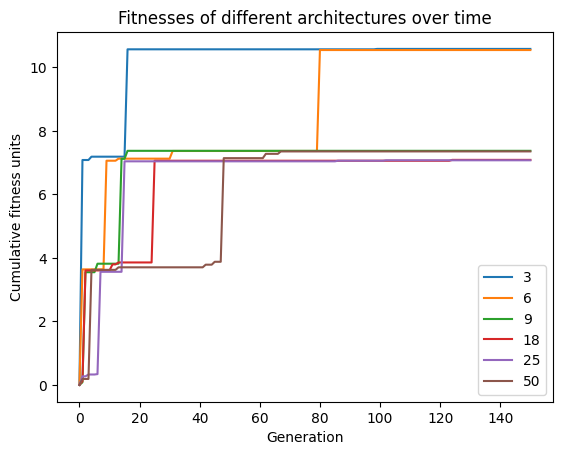

In [60]:
print(len(fitnesses))
labels=["3","6","9","18","25","50"]
for i in range(len(labels)):
    plt.plot(fitnesses[i],label=labels[i])
plt.title("Fitnesses of different architectures over time")
plt.xlabel("Generation")
plt.ylabel("Cumulative fitness units")
plt.legend(loc="lower right")
plt.show()

In [16]:
arr=[]
best=0
best_ind=0
highest=0
for ind in range(len(pop)):
    arr_=[]
    f_=0
    for i in range(3):
        f,r=run_trial(sensor,pop[ind],3,save=arr_)
        f_+=f
    f=f_/3
    h=np.sum(env.get_tactile_obs())
    if f>best:
        best=f
        best_ind=ind
        highest=f
        arr=copy.deepcopy(arr_)



In [21]:
def save_trial(sensor,genotype,max_t):
    dt=0.1
    t=0
    done=False
    r_sum = 0
    o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0
    step = 0
    sensor.set_genes(genotype) #set the gene of the robot
    im=get_image(o['tactile'],div=DIM)
    old=copy.deepcopy(im)
    images=np.zeros((int(max_t/dt)+1,128,128,1))
    arrows=np.zeros((int(max_t/dt)+1,2))

    while t<=max_t: #loop till sturdy or out of time
        tactile_input=get_image(o['tactile'],div=DIM)  
        
        a=sensor.get_action(tactile_input.flatten()) #push through tactile input into agent
        o, r, d, info = env.step(a) #step through environment
        images[step]=o['tactile']
        arrows[step]=a
        step+=1
        t+=dt #increase by timestep
    np.save("./images",images)
    np.save("./arrows",arrows)

save_trial(sensor,pop[best_ind],5)


In [62]:
#record_trial(sensor,pop[best_ind],5)
arr=[]
f,r=run_trial(sensor,pop[best_ind],10,save=arr)
clear_output()
import cv2 as cv
h,w=arr[0].shape[:2]
out = cv.VideoWriter('./Gym_tactip_lowres_linear.avi',cv.VideoWriter_fourcc(*'DIVX'), 10, (w,h))
#gen vid
for i,j in enumerate(arr):
    out.write(j)
out.release()

In [ ]:
np.save("./lowREs",pop[best_ind])
record_trial(sensor,pop[best_ind],5)
